In [ ]:
import cv2
import math
from cv2 import imshow
from cv2 import PSNR
import numpy as np
import csv
import timeit

In [ ]:
def calculate_psnr(img1, img2):
    img1 = img1.astype('float64')/255
    img2 = img2.astype('float64')/255
    img1=cv2.resize(img1,(400,600))
    img2=cv2.resize(img2,(400,600))
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


In [ ]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    img1=cv2.resize(img1,(400,600))
    img2=cv2.resize(img2,(400,600))
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [ ]:
def calculate_ssim(img1, img2):
    img1=cv2.resize(img1,(400,600))
    img2=cv2.resize(img2,(400,600))
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')


In [ ]:
def DarkChannel(im):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b)
    kernel = np.ones((5, 5), np.uint8)
    dark = cv2.erode(dc, kernel)
    return dark

##def LightChannel(dark):
   # b, g, r = cv2.split(dark)
   # lc = cv2.max(cv2.max(r, g), b)
   # kernel = np.ones((5, 5), np.uint8)
    #light = cv2.dilate(lc, kernel)
    #return light


def AtmLight(im, dark):
    [h, w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000), 1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz, 3)
    indices = darkvec.argsort()
    indices = indices[(imsz-numpx)::]
    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
       atmsum = atmsum + imvec[indices[ind]]
    A = atmsum / numpx
    return A

def Estimate_transmission(image, A):
    omega = 0.88
    image3 = np.empty(image.shape, image.dtype)
    for ind in range(0, 3):
        image3[:, :, ind] = image[:, :, ind]/A[0, ind]
    transmission = 1 - omega*DarkChannel(image3)
    return transmission

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im*p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I*mean_p
    mean_II = cv2.boxFilter(im*im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I*mean_I
    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))
    filter = mean_a*im + mean_b
    return filter


def Refine_Transmission(image, et):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = np.float64(gray_image)/255
    r = 60
    eps = 0.0001
    t = Guidedfilter(gray_image, et, r, eps)
    return t


def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype)
    t = cv2.max(t, tx)
    for ind in range(0, 3):
        res[:, :, ind] = (im[:, :, ind]-A[0, ind])/t + A[0, ind]
    return res

In [ ]:
input_path = "/content/test(1).png"

# Read the input hazy image
input_image = cv2.imread(input_path)
max_pixel_value = np.max(input_image)
I = input_image.astype('float64')/max_pixel_value

# Perform the dehazing process
dark = DarkChannel(I)
#light = LightChannel(dark) ;
A = AtmLight(I, dark)
te = Estimate_transmission(I, A)
t = Refine_Transmission(input_image, te)
J = Recover(I, t, A, 0.1)

# Save the dehazed output
output_path = "/content/output.jpg"
cv2.imwrite(output_path, J*max_pixel_value)

print("Dehazing complete. Dehazed image saved to:", output_path)

Dehazing complete. Dehazed image saved to: /content/output.jpg


In [ ]:
output_image = cv2.imread(output_path)

In [ ]:
#Adding the brightness and sharpning the image
brightness_factor = 5
final_out_image = cv2.add(output_image, brightness_factor)

In [ ]:
import matplotlib.pyplot as plt

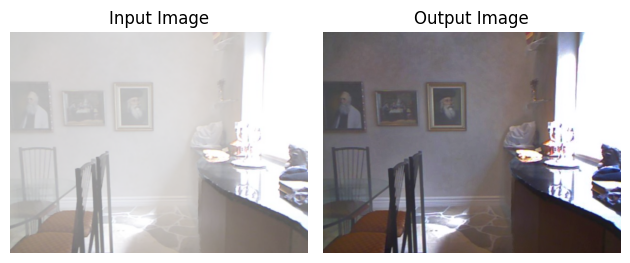

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Display the input image in the first subplot
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(final_out_image, cv2.COLOR_BGR2RGB))  # Display the output image in the second subplot
plt.title("Output Image")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
y = df['price']
x= df.drop('price',axis = 1)